In [20]:
import json
import matplotlib.pyplot as plt
from natsort import natsorted
import numpy as np
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
import pandas as pd
from scipy.optimize import linear_sum_assignment

In [21]:
def acc(labels_true, labels_pred):
    """
    References
    -------
    Yang, Yi, et al. "Image clustering using local discriminant models and global integration."
    IEEE Transactions on Image Processing 19.10 (2010): 2761-2773.
    """
    labels_true = np.array(labels_true)
    labels_pred = np.array(labels_pred)
    max_label = int(max(labels_pred.max(), labels_true.max()) + 1)
    match_matrix = np.zeros((max_label, max_label), dtype=np.int64)
    for i in range(labels_true.shape[0]):
        match_matrix[int(labels_true[i]), int(labels_pred[i])] -= 1
    indices = linear_sum_assignment(match_matrix)
    acc = -np.sum(match_matrix[indices]) / labels_pred.size
    return acc


def load_json_data(data_name):
    DATA_PATH = "datasets/data/" 
    f = open(DATA_PATH + data_name + ".json")
    data = json.load(f)
    return(data)

def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    M = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(M, axis=0)) / np.sum(M)

 
def compute_scores(partitions_by_run, true_labels):
    aris_list = []
    nmis_list = []
    accs_list = []
    inf_clusts_list = []
    for partition in partitions_by_run:
        if min(partition)==1:
            partition = list(map(lambda x: x-1,partition))
        aris_list.append(adjusted_rand_score(true_labels, partition))
        nmis_list.append(normalized_mutual_info_score(true_labels, partition))
        accs_list.append(acc(true_labels,partition))
        inf_clusts_list.append(max(partition)-min(partition)+1)
    return(aris_list, nmis_list, accs_list, inf_clusts_list)

def extract_results_from_dict(results, true_labels):
    running_time_list = results["runtimeList"]
    partitions_list = results["partitionsList"]
    ari_list, nmi_list, acc_list, inf_clusts_list = compute_scores(partitions_list, true_labels)
    return(ari_list, nmi_list,acc_list, running_time_list, inf_clusts_list, partitions_list) #likelihoods_list)
    

In [22]:
# specify the dataset name 
dataset_name = "EngyTime_4096_2_2"

# Load distributed DPMM results
f = open("results/Experience_results_{}.json".format(dataset_name))
results = json.load(f)

In [23]:
dataset = load_json_data(dataset_name)
data = np.array(dataset["data"])
t_labels = dataset["true labels"]
ari_list, nmi_list,acc_list, running_time_list, inf_clus_list, partitions_list = extract_results_from_dict(results,t_labels) 
print("{} |K: {} | ARI: {:.2f} +- {:.2f} | NMI: {:.2f} +- {:.2f} | ACC: {:.2f} +- {:.2f}"
    .format(dataset_name,
     max(t_labels)-min(t_labels)+1,
     np.array(ari_list).mean(),
     np.array(ari_list).std(),
     np.array(nmi_list).mean(),
     np.array(nmi_list).std(),
     np.array(acc_list).mean(),
     np.array(acc_list).std()))
print("\n")

EngyTime_4096_2_2 |K: 2 | ARI: 1.00 +- 0.00 | NMI: 0.99 +- 0.00 | ACC: 1.00 +- 0.00




### Visualization

In [24]:
best_partition = partitions_list[np.where(np.array(ari_list)==max(ari_list))[0][0]]

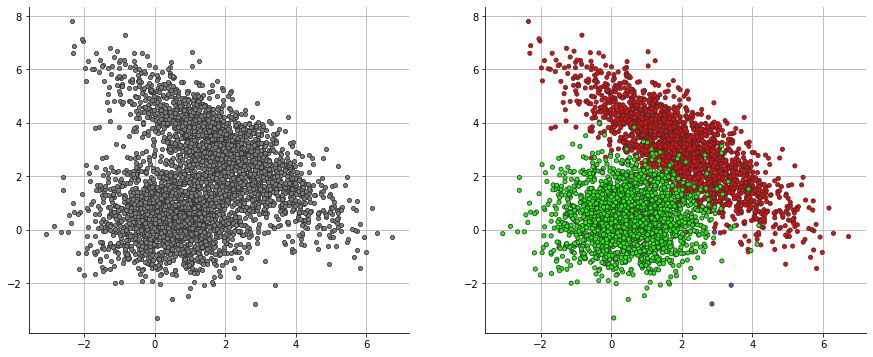

In [25]:
colors = ['#16FF00','#F273E6','#eaefd3' ,'#F273E6', '#FF0303',  '#1363DF',"#FFEA20", "#7149C6"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
ax1.scatter(data[:,0],data[:,1],edgecolors='#333333', linewidths = 0.8 , s=70, marker='.', c="gray")
ax1.set_axisbelow(True)
ax1.grid()

ax2.scatter(data[:,0],data[:,1], edgecolors='#333333', linewidths = 0.8 , s=70, marker='.', c=best_partition,
            cmap=plt.matplotlib.colors.ListedColormap(colors))
ax2.set_axisbelow(True)
ax2.grid()

plt.savefig("figure.png")
plt.show()